<a href="https://colab.research.google.com/github/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/03_full_acquisition_simulations/notebooks/Simulate_s05_3d_mtse__MaRCoS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MaRCoS system optimized 3D MTSE + MR-zero simulation (PDG)
* B0 = 72 mT, 3.05 MHz, 1 ppm = 3.05 Hz, dB0 ca. 100 ppm = 305 Hz

See description at
https://github.com/mritogether/ESMRMB2024_Hardware_to_Map/tree/main/03_full_acquisition_simulations


#Exercises or Games
*  Speedup
    * Reduce 3D dim of sequence
    * Reduce the size of the phantom
    * Reduce accuracy

* **Alter sequence**
  * FA 60 - 120
  *  spoiler too weak?
  *  timing wrong?
  *  phase investigations
* **Alter phantom**: only in simulation
  *  B1 influence on T2 decay
  *  T1 influence on T2 decay
  *  Diffusion affects T2 decay



# Code Sections for 3D MTSE forMaRCoS in a low field phantom

In [ ]:
#@title S0. environment setup (just need to run it one time)
!pip show pypulseq || pip install pypulseq &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as pp
# for simulation
!pip show MRzeroCore || pip install MRzeroCore &> /dev/null
import MRzeroCore as mr0
import torch
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/mzaiss/MRTwin_pulseq/raw/mr0-core/data/low_field_phantom.mat &> /dev/null

Name: pypulseq
Version: 1.4.2
Summary: Pulseq in Python
Home-page: https://github.com/imr-framework/pypulseq
Author: Keerthi Sravan Ravi
Author-email: ks3621@columbia.edu
License: License :: OSI Approved :: GNU Affero General Public License v3
Location: /usr/local/lib/python3.10/dist-packages
Requires: coverage, matplotlib, numpy, scipy, sigpy
Required-by: MRzeroCore
Name: MRzeroCore
Version: 0.3.5
Summary: Core functionality of MRzero
Home-page: 
Author: 
Author-email: Jonathan Endres <jonathan.endres@uk-erlangen.de>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, pydisseqt, pypulseq, requests, scikit-image, scipy, torch, torchkbnufft
Required-by: 


In [ ]:
  #@title S1. Pulseq sequence, wrapped as a function create_mtse
# %% SETUP system
  # choose the scanner limits
system = pp.Opts(
        max_grad=25,       # MaRCoS's limits are 25, 40 and 35 mT/m for X, Y and Z axes
        grad_unit="mT/m",
        max_slew=50,       # MaRCoS's limits are 50, 80 and 70 mT/m/ms for X, Y and Z, respectively
        slew_unit="T/m/s",
        rf_ringdown_time=15e-6,
        rf_dead_time=15e-6,
        adc_dead_time=0e-6 )

def plot_ktraj(seq):
    [k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc] = seq.calculate_kspace() #(gradient_offset=(3000,-2000,2000))

    n1 = 100000
    n2 = 100000
    plt.figure()
    plt.plot(k_traj[0,0:n1],k_traj[1,0:n1], 'b-')
    plt.plot(k_traj_adc[0,0:n2],k_traj_adc[1,0:n2], 'r.')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.title('k-space trajectory')
    plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
    plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
    plt.show()


def create_mtse(
    FAex=90,
    FAref=180,
    fsp_r=1,
    fov_mm=(150, 150, 150),
    nRD=40,
    nPH=40,
    n3D=10,
    n_echo=4,
    TE=15e-3,
    TR=300e-3,
    rdGradTime=5e-3,
    acqTime=4e-3,
    dG=500e-6,
    sampling_time=None,
    rd_flattop_add=None,
    nRD_pre=10,
    nRD_post=None,
    os=6,
    t_ex=60e-6,
    t_ref=100e-6,
    rf_ex_phase=np.pi/2,
    rf_ref_phase = 0, # phase of the refocusing pulse
    time_range=(0,0.375),
    verbose=0
):
    if sampling_time is None:
        sampling_time = acqTime
    if rd_flattop_add is None:
        rd_flattop_add = (rdGradTime - acqTime) / 2
    if nRD_post is None:
        nRD_post = nRD_pre

    # Create a new sequence object, needed for definitions
    seq = pp.Sequence(system)


    # derived and modifed parameters
    fov = np.array(fov_mm) * 1e-3 # FOV in meters
    TE = round(TE/system.grad_raster_time/2) * system.grad_raster_time * 2 # TE (=ESP) should be divisible to a double gradient raster, which simplifies calcuations
    rd_flattop_time = sampling_time + 2*rd_flattop_add ; # duration of the flat top of the read gradient
    rf_add = math.ceil(max(system.rf_dead_time,system.rf_ringdown_time)/system.grad_raster_time)*system.grad_raster_time # round up dead times to the gradient raster time to enable correct TE & ESP calculation
    t_sp = round((0.5 * (TE - rd_flattop_time - t_ref) - rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of gradient spoiler after the refocusing pulse
    t_spex = round((0.5 * (TE - t_ex - t_ref) - 2*rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of readout prephaser after the excitation pulse. note: exclude the RF ringdown time of excitation pulse and rf dead time of refocusing pulse

    # ======
    # CREATE EVENTS
    # ======
    # excitation and refocusing pulses
    flip_ex = FAex * np.pi / 180
    rf_ex = pp.make_block_pulse(
        flip_angle=flip_ex,
        system=system,
        duration=t_ex,
        delay=rf_add,
        phase_offset=rf_ex_phase )

    d_ex=pp.make_delay(t_ex+rf_add*2)

    flip_ref = FAref * np.pi / 180
    rf_ref = pp.make_block_pulse(
        flip_angle=flip_ref,
        system=system,
        duration=t_ref,
        delay=rf_add,
        phase_offset=rf_ref_phase,
        use="refocusing" )

    d_ref=pp.make_delay(t_ref+rf_add*2)

    delta_kx = 1 / fov[0]
    rd_amp = nRD * delta_kx / sampling_time

    gr_acq = pp.make_trapezoid(
        channel="x",
        system=system,
        amplitude = rd_amp,
        flat_time=rd_flattop_time,
        delay=t_sp,
        rise_time=dG )

    adc = pp.make_adc(
        num_samples=(nRD_pre+nRD+nRD_post)*os,
        dwell=sampling_time/nRD/os,
        delay=t_sp+dG-nRD_pre*sampling_time/nRD ) # nRD_pre*sampling_time/nRD: delay for additional ADC samples to initialize decimation filters prior to the 'sampling_time'

    gr_spr = pp.make_trapezoid(
        channel="x",
        system=system,
        area=gr_acq.area * fsp_r,
        duration=t_sp,
        rise_time=dG ) # qc: why spoiler in readout direction?

    agr_spr = gr_spr.area
    agr_preph = gr_acq.area / 2 + agr_spr # readout prephaser: account for readout pre-spoiler and readout gradient
    gr_preph = pp.make_trapezoid(
        channel="x", system=system, area=agr_preph, duration=t_spex, rise_time=dG )

    # Phase-encoding
    delta_ky = 1 / fov[1]
    gp_max = pp.make_trapezoid(
                    channel="y",
                    system=system,
                    area=delta_ky*nPH/2,
                    duration=t_sp,
                    rise_time=dG )

    # Partition encoding
    delta_kz = 1 / fov[2]
    gs_max = pp.make_trapezoid(
                    channel="z",
                    system=system,
                    area=delta_kz*n3D/2,
                    duration=t_sp,
                    rise_time=dG )
    # combine parts of the read gradient
    gc_times = np.array(
        [
            0,
            gr_spr.rise_time,
            gr_spr.flat_time,
            gr_spr.fall_time,
            gr_acq.flat_time,
            gr_spr.fall_time,
            gr_spr.flat_time,
            gr_spr.rise_time ] )
    gc_times = np.cumsum(gc_times)

    gr_amp = np.array([0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude, gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0])
    gr = pp.make_extended_trapezoid(channel="x", times=gc_times, amplitudes=gr_amp)

    gp_amp = np.array([0, gp_max.amplitude, gp_max.amplitude, 0, 0, -gp_max.amplitude, -gp_max.amplitude, 0])
    gp_max = pp.make_extended_trapezoid(channel="y", times=gc_times, amplitudes=gp_amp)

    gs_amp = np.array([0, gs_max.amplitude, gs_max.amplitude, 0, 0, -gs_max.amplitude, -gs_max.amplitude, 0])
    gs_max = pp.make_extended_trapezoid(channel="z", times=gc_times, amplitudes=gs_amp)

    # Fill-times
    t_ex = pp.calc_duration(d_ex) + pp.calc_duration(gr_preph)
    t_ref = pp.calc_duration(d_ref) + pp.calc_duration(gr)

    t_train = t_ex + n_echo * t_ref

    TR_fill = TR - t_train
    # Round to gradient raster
    TR_fill = system.grad_raster_time * np.round(TR_fill / system.grad_raster_time)
    if TR_fill < 0:
        TR_fill = 1e-3
        warnings.warn(
            f"TR too short, adapted to: {1000 * (t_train + TR_fill)} ms"
        )
    else:
        print(f"TR fill: {1000 * TR_fill} ms")
    delay_TR = pp.make_delay(TR_fill)

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    for Cz in range(-1,n3D):
        if Cz >= 0:
            sl_scale = (Cz-n3D/2)/n3D*2; # from -1 to +1
            nPH_range=range(nPH)
        else:
            sl_scale = 0.0
            nPH_range=range(1) # skip the nPH loop for dummy scan(s)

        gs=pp.scale_grad(gs_max, sl_scale)

        for Cy in nPH_range:
            seq.add_block(rf_ex, d_ex)
            seq.add_block(gr_preph)

            if Cz >= 0:
                pe_scale = (Cy-nPH/2)/nPH*2; # from -1 to 1
            else:
                pe_scale = 0.0

            gp=pp.scale_grad(gp_max, pe_scale)

            for k_echo in range(n_echo):

                seq.add_block(rf_ref, d_ref)
                if Cz >= 0:
                    seq.add_block(gs, gp, gr, adc)
                else:
                    seq.add_block(gs, gp, gr)

            seq.add_block(delay_TR)


    # ======
    # VISUALIZATION
    # ======
    if verbose:
      seq.plot(time_range=time_range)
      plot_ktraj(seq)

      #(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
      #if ok:
      #  print("Timing check passed successfully")
      #else:
      #  print("Timing check failed. Error listing follows:")
      #  [print(e) for e in error_report]

    # Prepare the sequence output for the scanner
    seq.write('external.seq')

    return seq

create_mtse(fsp_r=0)


TR fill: 232.52000000000004 ms


#Run all below wrapper

TR fill: 217.52 ms


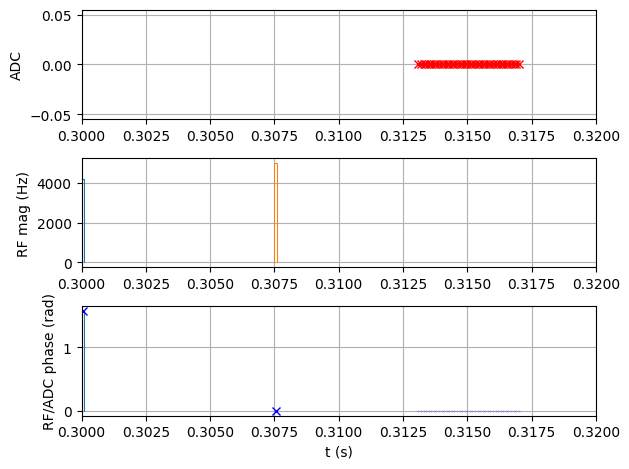

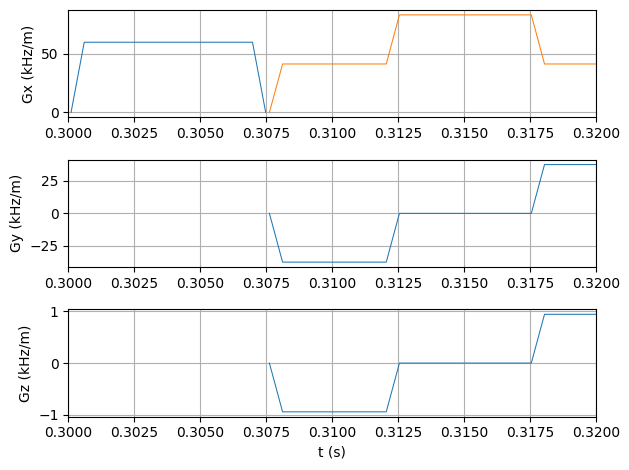

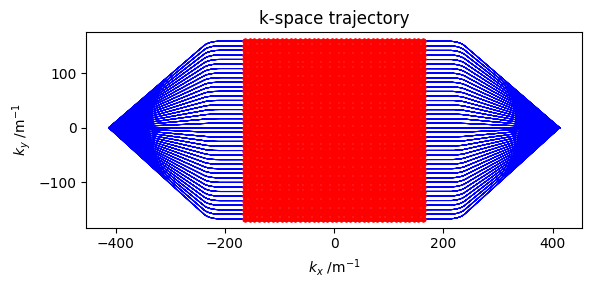

In [ ]:
#@title  S2. interactive changes on seq
#@markdown seq=create_mtse(
FAex = 90 #@param {type:"slider", min:1, max:90, step:1}
FAref = 180 #@param {type:"slider", min:1, max:180, step:1}
fov_x =  120#param {type:"integer"}
fov_y =  120#param {type:"integer"}
fov_z =  120#param {type:"integer"}
nRD =  40#@param {type:"slider", min:0, max:80, step:1}
nPH =  40#@param {type:"slider", min:0, max:80, step:1}
n3D =  1 #@param {type:"slider", min:1, max:20, step:1}
n_echo =  5#@param {type:"slider", min:0, max:8, step:1}
TE =  15e-3#@param {type:"number"}
TR =  300e-3#@param {type:"number"}
rdGradTime =  5e-3 #param {type:"number"}
acqTime = 4e-3 #param {type:"number"}
dG = 500e-6 #param {type:"number"}
sampling_time =  4e-3#param {type:"number"}
fsp_r = 0.4 #@param {type:"slider", min:0, max:3, step:0.1}
rd_flattop_add =  0.5e-3#@param {type:"number"}
nRD_pre =  0#@param {type:"slider", min:0, max:20, step:1}
nRD_post =  0#@param {type:"slider", min:0, max:20, step:1}
os =  1#@param {type:"slider", min:1, max:12, step:1}
t_ex =  60e-6#param {type:"number"}
t_ref =  100e-6#param {type:"number"}
rf_ex_phase =  90 #@param {type:"slider", min:0, max:180, step:45}
rf_ex_phase*=np.pi/180
rf_ref_phase =  0 #param {type:"slider", min:0, max:180, step:45}
rf_ref_phase*=np.pi/180
t0=0.3 #@param {type:"number"}
t1=0.32 #@param {type:"number"}
#@markdown )
seq=create_mtse(verbose=True,FAex=FAex,FAref=FAref,fsp_r=fsp_r, fov_mm=(fov_x, fov_y, fov_z), nRD=nRD, nPH=nPH, n3D=n3D, n_echo=n_echo, TE=TE, TR=TR, rdGradTime=rdGradTime, acqTime=acqTime, dG=dG, sampling_time=sampling_time, rd_flattop_add=rd_flattop_add, nRD_pre=nRD_pre, nRD_post=nRD_post, os=os, t_ex=t_ex, t_ref=t_ref, rf_ex_phase=rf_ex_phase, rf_ref_phase = rf_ref_phase,time_range=(t0, t1))

VoxelGridPhantom
size = tensor([0.1200, 0.1200, 0.1200])


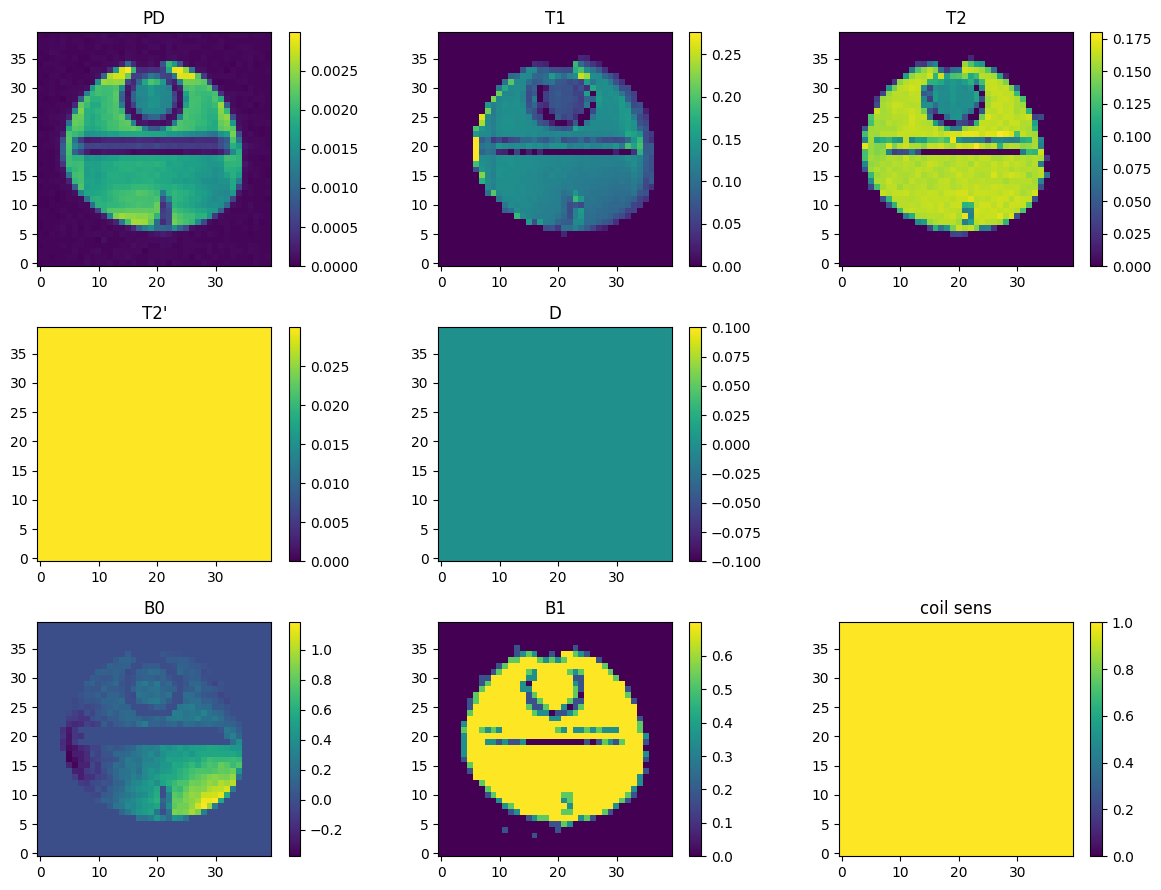

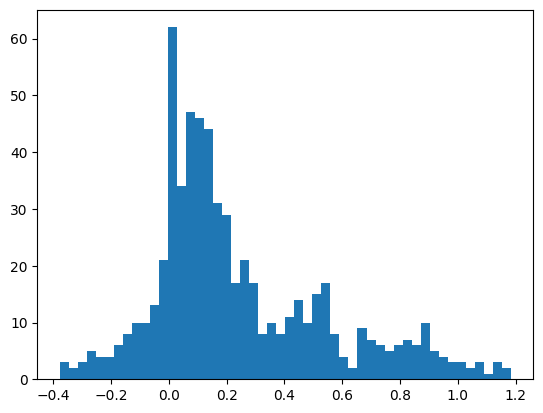

0.24243459 0.07948675116554636
0.3071234 0.10069619436733059


In [ ]:
#@title S3. Load phantom and manipulate
dB0 = 0
phantom_fn = "low_field_phantom.mat" # @param ["low_field_phantom.mat","numerical_brain_cropped"] {allow-input: true}
slice_select =  [10] # @param {type:"raw"}
sz = [100, 100, 1]
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
obj_p = mr0.VoxelGridPhantom.load_mat(phantom_fn)
obj_p.T2dash[:] = 30e-3 # this is set within load_mat, change here.
obj_p.B0/=2*np.pi

#obj_p = obj_p.interpolate(40, 40, 16) # all slices

if slice_select == [-1]:
  obj_p = obj_p.interpolate(40, 40, 16) # all slices
else:
  obj_p = obj_p.interpolate(40, 40, 16).slices(slice_select)  # reduced slices
# change the size in SI untis (m), here 12 cm
obj_p.size = torch.tensor([0.12,0.12,0.12])
# Manipulate loaded data
rB1_factor= 0.7 # @param {type: "slider", min: 0.1, max: 2.0, step:0.1}
dB0_factor= 0.001 # @param {type: "slider", min: 0.001, max: 6.0, step:0.001}
T1_factor= 1.0 # @param {type: "slider", min: 0.1, max: 2.0, step:0.1}
T2_factor= 1.014 # @param {type: "slider", min: 0.1, max: 2.0, step:0.001}
T2dash_factor= 1.0 # @param {type: "slider", min: 0.1, max: 2.0, step:0.001}
D = 0.0 # @param {type: "slider", min: 0.0, max: 5.0}

obj_p.T1*= torch.tensor(T1_factor)
obj_p.T2*= T2_factor
obj_p.T2dash*= T2dash_factor
obj_p.B1*= rB1_factor
obj_p.B0*= dB0_factor
obj_p.D[:]= D
obj_p.plot()

# Store PD and B0 before sparsifying for later comparison
PD = obj_p.PD
B0 = obj_p.B0
T2 = obj_p.T2

# Convert Phantom into simulation data
obj_p=obj_p.build()

plt.hist(B0[PD>0.0005].flatten(), bins=50)
plt.show()
mB0=np.mean(B0[PD>0.0005].flatten().numpy())
stdB0=np.std(B0[PD>0.0005].flatten().numpy())
print(mB0,mB0/3.05)
print(stdB0,stdB0/3.05)

Calculating repetition 246 / 246 - done


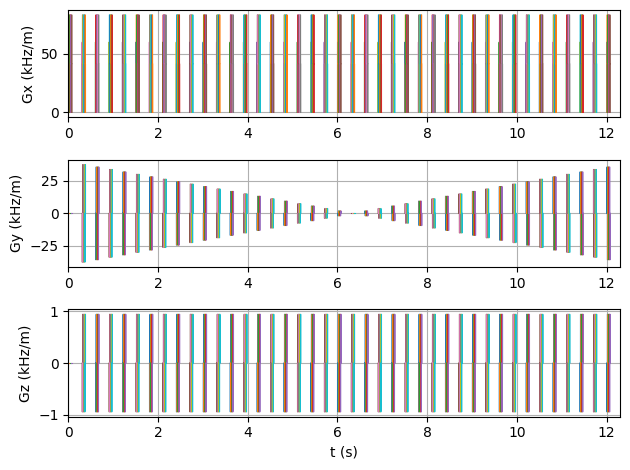

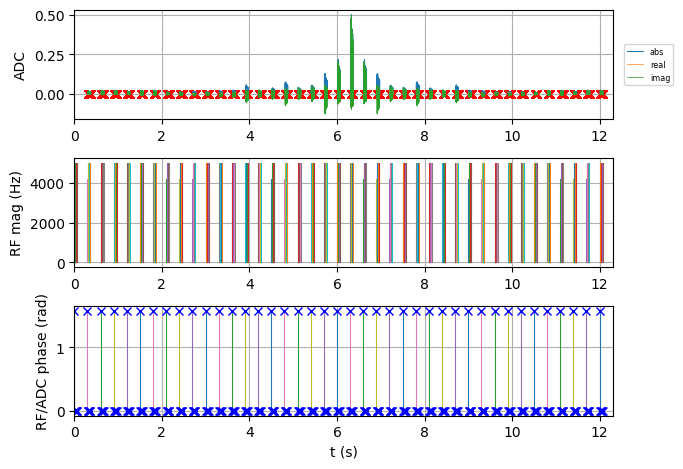

In [ ]:
#@title S4. Simulate
# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file('external.seq')
#seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 1000, 1e-3)
use_gpu=torch.cuda.is_available()
if use_gpu:
  signal = mr0.execute_graph(graph, seq0.cuda(), obj_p.cuda(),min_emitted_signal=0.01,min_latent_signal=0.01)
  signal=signal.cpu()
else:
  signal = mr0.execute_graph(graph, seq0, obj_p,min_emitted_signal=0.01,min_latent_signal=0.01)
# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


In [ ]:
#@title S5. Explore Interactive seq.plot() - experimental
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive
from IPython.display import display
import ipywidgets as widgets

plt.ioff()  # Turn off interactive mode

def plot_sine(plot=False,full=False, sec=0, t0=0,dt=1):
  if plot:
    if full:
      seq.plot(plot_now=False)
      mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
    else:
      seq.plot(plot_now=False, time_range=(sec+t0, sec+t0+dt))
      mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
    plt.show()

interactive_plot = interactive(plot_sine,full=True,plot=False,
                               sec=widgets.IntSlider(min=0, max=100, step=1, value=6),
                               t0=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.29),
                               dt=widgets.FloatSlider(min=0, max=0.5, step=0.01, value=0.15))
display(interactive_plot)

interactive(children=(Checkbox(value=False, description='plot'), Checkbox(value=True, description='full'), Int…

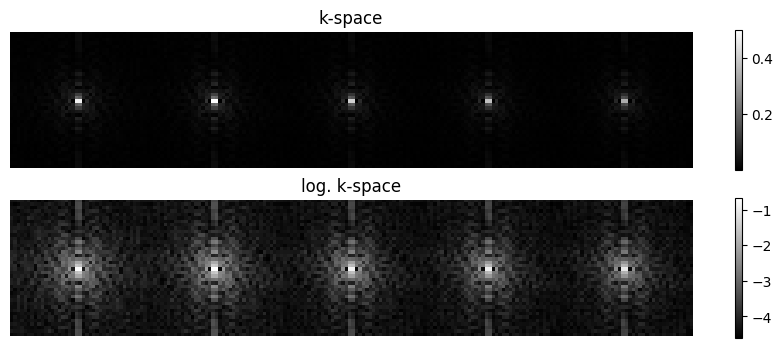

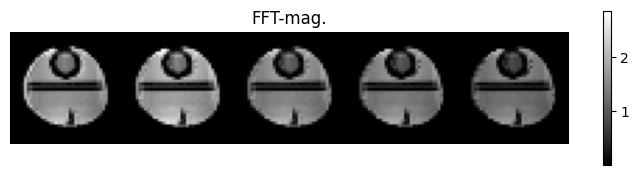

In [ ]:
#@title S6. Reconstruction and image display

# additional noise as simulation is ideal
signal_1 = signal + 1e-6 * np.random.randn(signal.shape[0], 2).view(np.complex128)


# 3D FFT
def fft_3d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x, axes=(0, 1, 3)), axes=(0, 1, 3)), axes=(0, 1, 3))

kspace = np.reshape(signal_1, (n3D, nPH, n_echo, os*(nRD+nRD_pre+nRD_post)))
kspace = kspace[:,:,:,os*(nRD_pre):os*(nRD_pre+nRD)]

im = fft_3d(kspace)
im = im[:,:,:,round(os*nRD/2-nRD/2):round(os*nRD/2+nRD/2)]
#kspace = np.reshape(signal, (n3D, nPH, n_echo, os*(nRD+nRD_pre+nRD_post)))
#kspace = kspace[:,:,:,round(os*nRD/2-nRD/2):round(os*nRD/2+nRD/2)]

slice=n3D//2
plt.figure(figsize=(11, 4))
plt.subplot(211)
plt.title('k-space')
plt.imshow(np.abs(kspace[slice,:,:,:].reshape(nPH,os*nRD*n_echo)),aspect=os,cmap='gray'); plt.axis('off');plt.colorbar()
plt.subplot(212)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace[slice,:,:,:].reshape(nPH,os*nRD*n_echo))+0.01),aspect=os,cmap='gray'); plt.axis('off');plt.colorbar()
plt.show()

plt.figure(figsize=(9, 2))
plt.title('FFT-mag.')
plt.imshow(np.abs(im[slice,:,:,:].reshape(nPH,nRD*n_echo)), origin="lower",cmap='gray'); plt.axis('off');plt.colorbar()
plt.show()


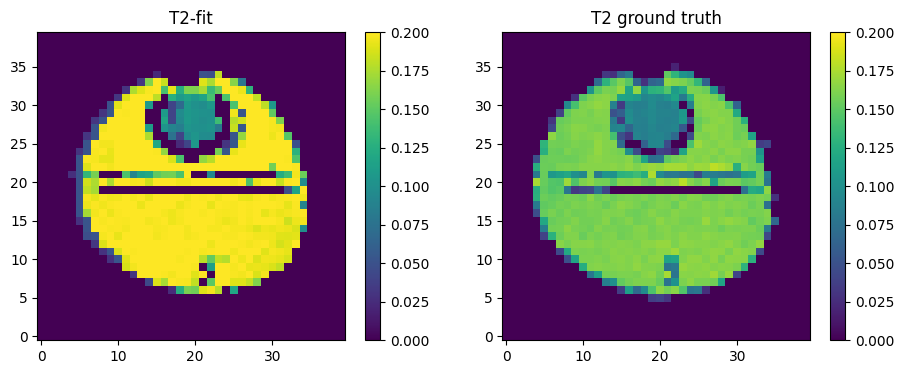

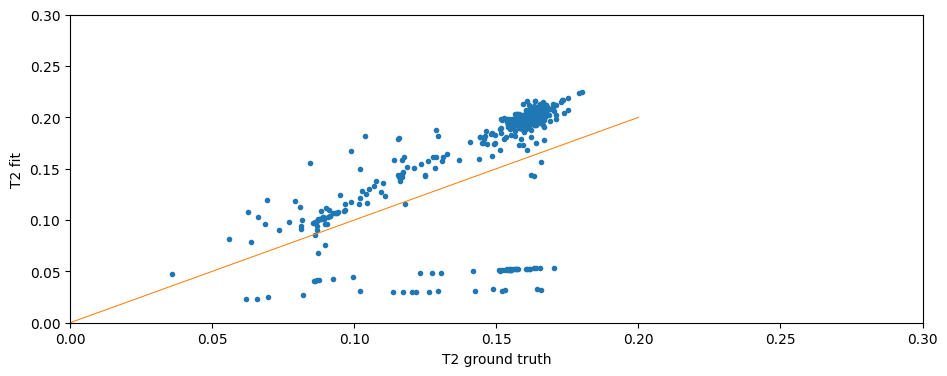

In [ ]:
#@title S7. T2 fit

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def func(t, a, T2):
  return a * np.exp(-t/T2)

t = (1+np.arange(n_echo)) * TE
S= np.abs(im[slice,:,:,:])
a_map = np.zeros((nPH, nRD))
T2_map = np.ones((nPH, nRD))*0
for x in range(nPH):
    for y in range(nRD):
        if S[x,0,y]>np.mean(S[:,0,:].flatten())*0.4:
          popt, pcov = curve_fit(func, t,S[x,:,y],p0=(S[x,0,y],0.01))
          a_map[x,y] = popt[0]
          T2_map[x,y] = popt[1]


plt.figure(figsize=(11, 4))
plt.subplot(121), plt.title('T2-fit')
plt.imshow(T2_map,vmin=0,vmax=0.2,origin='lower'); plt.colorbar();
plt.subplot(122), plt.title('T2 ground truth')
plt.imshow(T2.transpose(0,1),vmin=0,vmax=0.2,origin='lower'); plt.colorbar();
plt.show()

# Regression Plot
# Remove zero valued voxels
T2_np = T2.numpy().T.flatten()
T2_map_np = T2_map.flatten()
mask = (T2_np != 0) & (T2_map_np != 0)
T2_np = T2_np[mask]
T2_map_np = T2_map_np[mask]

plt.figure(figsize=(11, 4))
plt.plot(T2_np, T2_map_np, '.') # convert to numpy array and flatten for plotting
plt.plot([0,0.2],[0.0,0.2])
plt.axis([0,0.3,0,0.3])
plt.xlabel('T2 ground truth')
plt.ylabel('T2 fit')
plt.show()


# Matlab Code for generating phantoms in MR-zero
https://github.com/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/03_full_acquisition_simulations/notebooks/generate_MR0_phantom.m

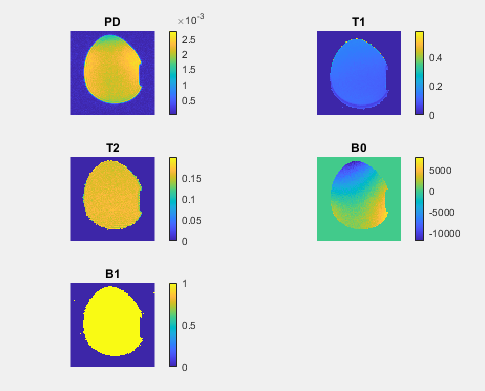